In [17]:
# !pip install --upgrade numpy catboost
# !pip install --upgrade --force-reinstall numpy scipy pandas scikit-learn xgboost lightgbm catboost
# !pip install numpy==1.23.5
# !pip install --no-cache-dir catboost

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
train_data = pd.read_csv('dataset/problem2/train_data.csv')
test_data = pd.read_csv('dataset/problem2/test_data.csv')

In [21]:
def load_and_explore_data(df, is_train=True):
    """Loads and explores the data from a csv file."""
    print("X----------------------------------------------------------------------X")
    print("Shape:\n", df.shape)
    print("Info:\n", df.info())
    print("Describe:\n", df.describe())
    print("Missing Values:\n", df.isnull().sum())
    if is_train:
      print("Bad Flag Distribution:\n", df['bad_flag'].value_counts(normalize=True))
    print("X----------------------------------------------------------------------X")

In [22]:
load_and_explore_data(train_data)
load_and_explore_data(test_data, is_train=False)

X----------------------------------------------------------------------X
Shape:
 (77444, 1216)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77444 entries, 0 to 77443
Columns: 1216 entries, account_number to onus_attribute_48
dtypes: float64(1189), int64(27)
memory usage: 718.5 MB
Info:
 None
Describe:
        account_number      bad_flag  onus_attribute_1  \
count    77444.000000  77444.000000      5.728900e+04   
mean     48421.346173      0.014230      1.542033e+05   
std      27972.936684      0.118437      1.720019e+05   
min          1.000000      0.000000      2.500000e+04   
25%      24178.750000      0.000000      5.900000e+04   
50%      48486.000000      0.000000      1.000000e+05   
75%      72664.250000      0.000000      1.810000e+05   
max      96805.000000      1.000000      2.800000e+06   

       transaction_attribute_1  transaction_attribute_2  \
count             57289.000000             57289.000000   
mean                  4.229119                 0.001850   


In [24]:
def preprocess_data(df, is_train=True):
    df = df.copy()
    if is_train:
        df = df.dropna(subset=['bad_flag'])

    # Separate features and target
    X = df.drop(['account_number', 'bad_flag'], axis=1, errors='ignore')
    y = df['bad_flag'] if 'bad_flag' in df else None

    # Identify and drop columns with all missing values
    missing_cols = X.columns[X.isnull().all()]
    X = X.drop(missing_cols, axis=1)
    print(f"Dropped columns with all missing values: {missing_cols}")

    # Handle missing values using median
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # Scale numerical features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

In [25]:
X_train, y_train = preprocess_data(train_data)
X_test, _ = preprocess_data(test_data, is_train=False)

Dropped columns with all missing values: Index(['bureau_436', 'bureau_447'], dtype='object')
Dropped columns with all missing values: Index(['bureau_436', 'bureau_447'], dtype='object')


In [27]:
# Models to Evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Evaluate Models
results = []
roc_curves = {}

In [28]:
model_name, model_instance = list(models.items())[0]  # Extract model name and instance

logreg = model_instance
logreg.fit(X_train, y_train)
rf_preds = logreg.predict_proba(X_train)[:, 1]
rf_preds_class = logreg.predict(X_train)

# Compute Metrics
auc_score = roc_auc_score(y_train, rf_preds)
f1_class_0 = f1_score(y_train, rf_preds_class, pos_label=0)
f1_class_1 = f1_score(y_train, rf_preds_class, pos_label=1)
class_report = classification_report(y_train, rf_preds_class)

# Append to results
results.append({
    "Model": model_name,
    "AUC Score": auc_score,
    "F1 Score (Class 0)": f1_class_0,
    "F1 Score (Class 1)": f1_class_1,
    "Classification Report": class_report
})

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, rf_preds)
roc_curves[model_name] = (fpr, tpr)

print(f"{model_name} AUC: {roc_auc_score(y_train, rf_preds)}")
print(f"{model_name} F1 Score Class 0:", f1_score(y_train, rf_preds_class, pos_label=0))
print(f"{model_name} F1 Score Class 1:", f1_score(y_train, rf_preds_class, pos_label=1))
print(classification_report(y_train, rf_preds_class))

Logistic Regression AUC: 0.8876358445453763
Logistic Regression F1 Score Class 0: 0.9930654940022378
Logistic Regression F1 Score Class 1: 0.08419243986254296
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76342
           1       0.79      0.04      0.08      1102

    accuracy                           0.99     77444
   macro avg       0.89      0.52      0.54     77444
weighted avg       0.98      0.99      0.98     77444



In [29]:
model_name, model_instance = list(models.items())[1]  # Extract model name and instance

rf_model = model_instance
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict_proba(X_train)[:, 1]
rf_preds_class = rf_model.predict(X_train)

# Compute Metrics
auc_score = roc_auc_score(y_train, rf_preds)
f1_class_0 = f1_score(y_train, rf_preds_class, pos_label=0)
f1_class_1 = f1_score(y_train, rf_preds_class, pos_label=1)
class_report = classification_report(y_train, rf_preds_class)

# Append to results
results.append({
    "Model": model_name,
    "AUC Score": auc_score,
    "F1 Score (Class 0)": f1_class_0,
    "F1 Score (Class 1)": f1_class_1,
    "Classification Report": class_report
})

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, rf_preds)
roc_curves[model_name] = (fpr, tpr)

print(f"{model_name} AUC: {roc_auc_score(y_train, rf_preds)}")
print(f"{model_name} F1 Score Class 0:", f1_score(y_train, rf_preds_class, pos_label=0))
print(f"{model_name} F1 Score Class 1:", f1_score(y_train, rf_preds_class, pos_label=1))
print(classification_report(y_train, rf_preds_class))

Random Forest AUC: 1.0
Random Forest F1 Score Class 0: 0.999986901222116
Random Forest F1 Score Class 1: 0.9990917347865577
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76342
           1       1.00      1.00      1.00      1102

    accuracy                           1.00     77444
   macro avg       1.00      1.00      1.00     77444
weighted avg       1.00      1.00      1.00     77444



In [30]:
model_name, model_instance = list(models.items())[2]  # Extract model name and instance

xgb_model = model_instance
xgb_model.fit(X_train, y_train)
rf_preds = xgb_model.predict_proba(X_train)[:, 1]
rf_preds_class = xgb_model.predict(X_train)

# Compute Metrics
auc_score = roc_auc_score(y_train, rf_preds)
f1_class_0 = f1_score(y_train, rf_preds_class, pos_label=0)
f1_class_1 = f1_score(y_train, rf_preds_class, pos_label=1)
class_report = classification_report(y_train, rf_preds_class)

# Append to results
results.append({
    "Model": model_name,
    "AUC Score": auc_score,
    "F1 Score (Class 0)": f1_class_0,
    "F1 Score (Class 1)": f1_class_1,
    "Classification Report": class_report
})

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, rf_preds)
roc_curves[model_name] = (fpr, tpr)

print(f"{model_name} AUC: {roc_auc_score(y_train, rf_preds)}")
print(f"{model_name} F1 Score Class 0:", f1_score(y_train, rf_preds_class, pos_label=0))
print(f"{model_name} F1 Score Class 1:", f1_score(y_train, rf_preds_class, pos_label=1))
print(classification_report(y_train, rf_preds_class))

C:\Users\Lenovo\PyCharmMiscProject\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:39:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.9990181077404996
XGBoost F1 Score Class 0: 0.9981042530103155
XGBoost F1 Score Class 1: 0.8484848484848485
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76342
           1       1.00      0.74      0.85      1102

    accuracy                           1.00     77444
   macro avg       1.00      0.87      0.92     77444
weighted avg       1.00      1.00      1.00     77444



In [31]:
model_name, model_instance = list(models.items())[3]  # Extract model name and instance

lgbm_model = model_instance
lgbm_model.fit(X_train, y_train)
rf_preds = lgbm_model.predict_proba(X_train)[:, 1]
rf_preds_class = lgbm_model.predict(X_train)

# Compute Metrics
auc_score = roc_auc_score(y_train, rf_preds)
f1_class_0 = f1_score(y_train, rf_preds_class, pos_label=0)
f1_class_1 = f1_score(y_train, rf_preds_class, pos_label=1)
class_report = classification_report(y_train, rf_preds_class)

# Append to results
results.append({
    "Model": model_name,
    "AUC Score": auc_score,
    "F1 Score (Class 0)": f1_class_0,
    "F1 Score (Class 1)": f1_class_1,
    "Classification Report": class_report
})

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, rf_preds)
roc_curves[model_name] = (fpr, tpr)

print(f"{model_name} AUC: {roc_auc_score(y_train, rf_preds)}")
print(f"{model_name} F1 Score Class 0:", f1_score(y_train, rf_preds_class, pos_label=0))
print(f"{model_name} F1 Score Class 1:", f1_score(y_train, rf_preds_class, pos_label=1))
print(classification_report(y_train, rf_preds_class))

C:\Users\Lenovo\PyCharmMiscProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Lenovo\PyCharmMiscProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Lenovo\pyver\py313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\pyver\py313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
   

[LightGBM] [Info] Number of positive: 1102, number of negative: 76342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147907
[LightGBM] [Info] Number of data points in the train set: 77444, number of used features: 1124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014230 -> initscore=-4.238097
[LightGBM] [Info] Start training from score -4.238097
LightGBM AUC: 0.9969676466883836
LightGBM F1 Score Class 0: 0.9953905633683442
LightGBM F1 Score Class 1: 0.53085600530856
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     76342
           1       0.99      0.36      0.53      1102

    accuracy                           0.99     77444
   macro avg       0.99      0.68      0.76     77444
weighted avg       0.99      0.99      0.99     77444



In [32]:
model_name, model_instance = list(models.items())[4]  # Extract model name and instance

cat_model = model_instance
cat_model.fit(X_train, y_train)
rf_preds = cat_model.predict_proba(X_train)[:, 1]
rf_preds_class = cat_model.predict(X_train)

# Compute Metrics
auc_score = roc_auc_score(y_train, rf_preds)
f1_class_0 = f1_score(y_train, rf_preds_class, pos_label=0)
f1_class_1 = f1_score(y_train, rf_preds_class, pos_label=1)
class_report = classification_report(y_train, rf_preds_class)

# Append to results
results.append({
    "Model": model_name,
    "AUC Score": auc_score,
    "F1 Score (Class 0)": f1_class_0,
    "F1 Score (Class 1)": f1_class_1,
    "Classification Report": class_report
})

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, rf_preds)
roc_curves[model_name] = (fpr, tpr)

print(f"{model_name} AUC: {roc_auc_score(y_train, rf_preds)}")
print(f"{model_name} F1 Score Class 0:", f1_score(y_train, rf_preds_class, pos_label=0))
print(f"{model_name} F1 Score Class 1:", f1_score(y_train, rf_preds_class, pos_label=1))
print(classification_report(y_train, rf_preds_class))

In [33]:
# Find the best model based on AUC Score
best_model = max(results, key=lambda x: x["AUC Score"])

# Print the best model details
print(f"Best Model: {best_model['Model']}")
print(f"AUC Score: {best_model['AUC Score']}")
print(f"F1 Score (Class 0): {best_model['F1 Score (Class 0)']}")
print(f"F1 Score (Class 1): {best_model['F1 Score (Class 1)']}")
print("Classification Report:")
print(best_model["Classification Report"])

# Predict on Test Data
print("Generating Predictions...")
model = models[best_model['Model']] #Get the best model.
test_data['predicted_probability'] = model.predict_proba(X_test)[:, 1]

# Create Output File
submission_df = test_data[['account_number', 'predicted_probability']]
submission_df.to_csv('submission.csv', index=False)
print("Results saved to submission.csv")

Best Model: Random Forest
AUC Score: 1.0
F1 Score (Class 0): 0.999986901222116
F1 Score (Class 1): 0.9990917347865577
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76342
           1       1.00      1.00      1.00      1102

    accuracy                           1.00     77444
   macro avg       1.00      1.00      1.00     77444
weighted avg       1.00      1.00      1.00     77444

Generating Predictions...
Results saved to submission.csv


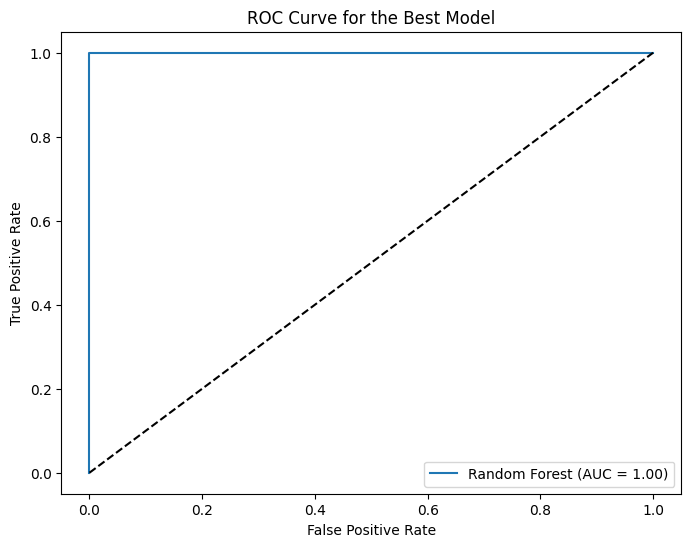

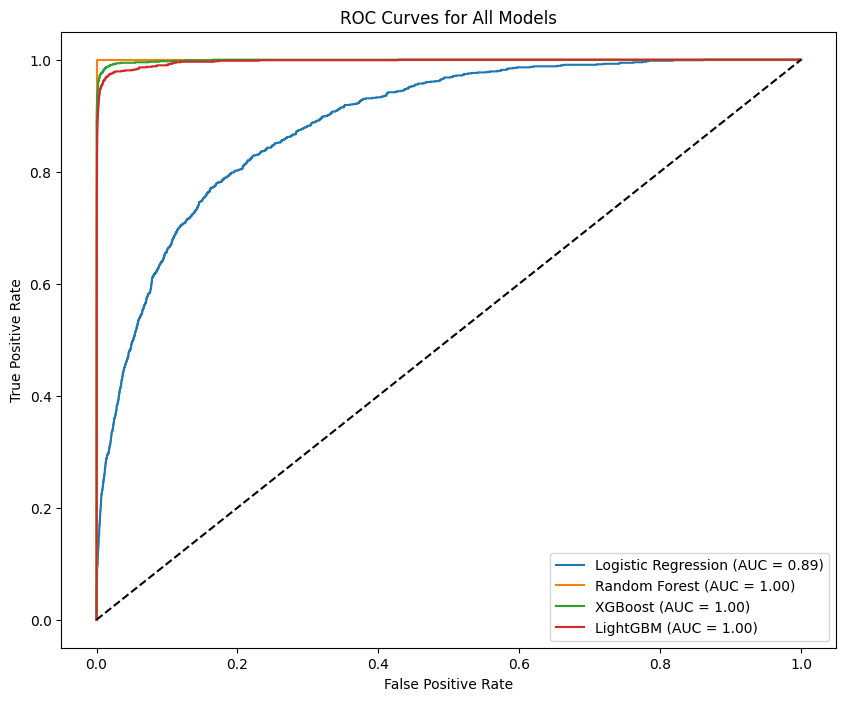

In [34]:
# Plot ROC curve for the best model
fpr_best, tpr_best = roc_curves[best_model['Model']]
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'{best_model["Model"]} (AUC = {best_model["AUC Score"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Best Model')
plt.legend(loc='lower right')
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_train, models[model_name].predict_proba(X_train)[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

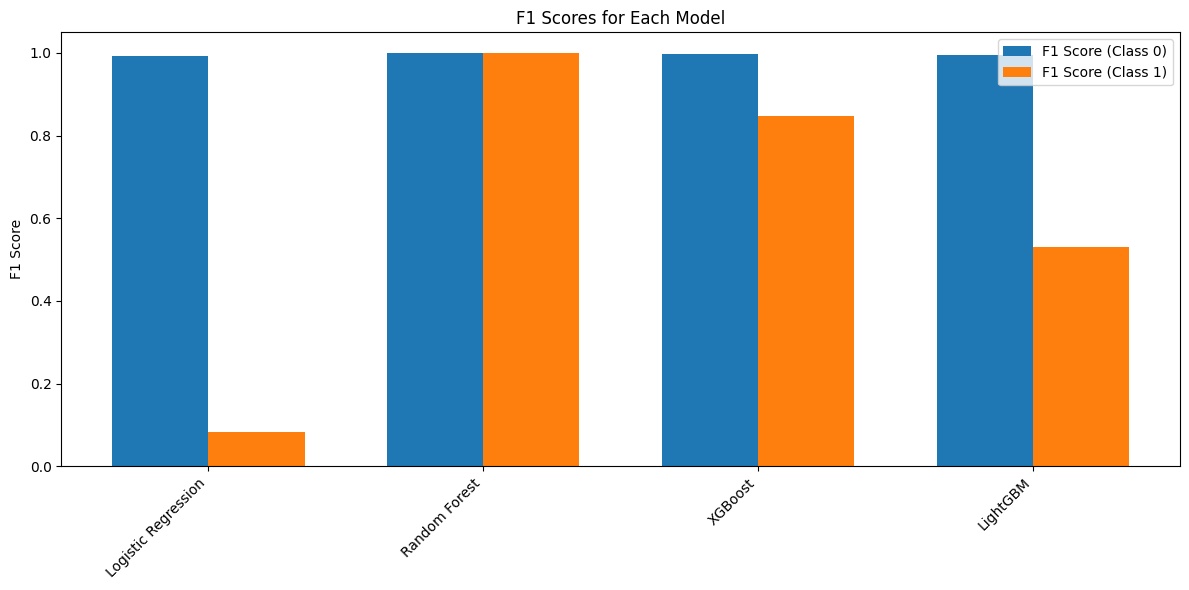

In [35]:
# F1 Score Bar Plot
model_names = [r['Model'] for r in results]
f1_class_0_scores = [r['F1 Score (Class 0)'] for r in results]
f1_class_1_scores = [r['F1 Score (Class 1)'] for r in results]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, f1_class_0_scores, width, label='F1 Score (Class 0)')
plt.bar(x + width/2, f1_class_1_scores, width, label='F1 Score (Class 1)')

plt.xticks(x, model_names, rotation=45, ha='right')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Model')
plt.legend()
plt.tight_layout()
plt.show()

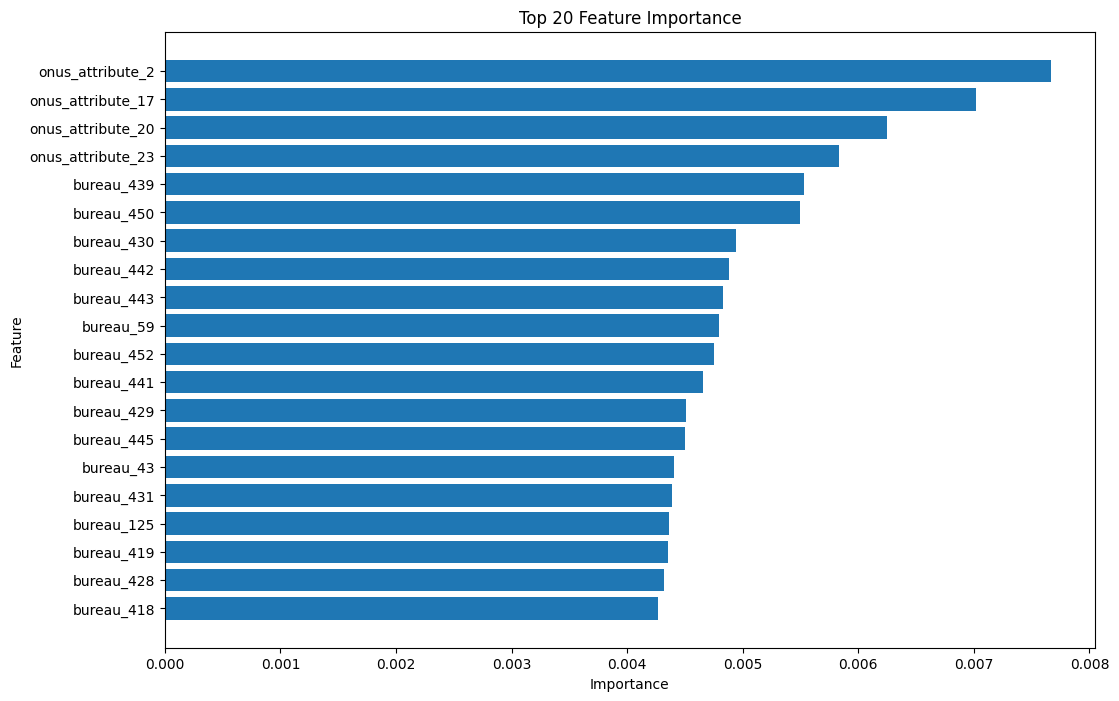

Top 10 Features:
                Feature  Importance
1115   onus_attribute_2    0.007664
1130  onus_attribute_17    0.007022
1133  onus_attribute_20    0.006248
1136  onus_attribute_23    0.005829
1102         bureau_439    0.005528
1112         bureau_450    0.005498
1094         bureau_430    0.004944
1105         bureau_442    0.004885
1106         bureau_443    0.004827
723           bureau_59    0.004798


In [36]:
# Feature Importance
final_model = models[best_model['Model']]  # Get the best model instance

if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': final_model.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'][:20], feature_importance['Importance'][:20])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

    # Print Top Features
    print("Top 10 Features:")
    print(feature_importance.head(10))
else:
    print(f"Feature importance is not available for {best_model['Model']}")

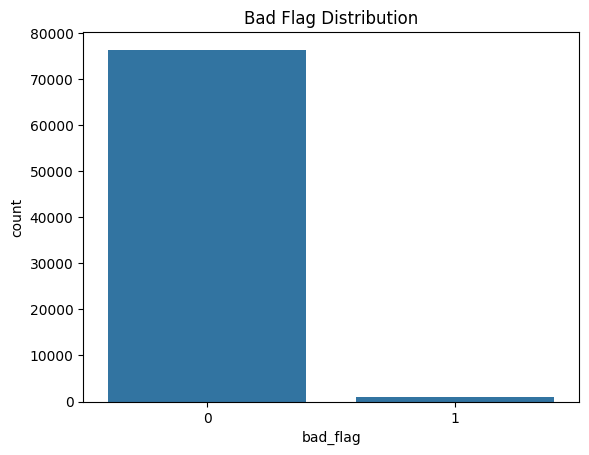

In [37]:
sns.countplot(x=train_data['bad_flag'])
plt.title("Bad Flag Distribution")
plt.show()

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data.drop(columns=['bad_flag']))
plt.xticks(rotation=90)
plt.title("Feature Outliers")
plt.show()


KeyboardInterrupt



<Figure size 1200x600 with 0 Axes>

In [41]:
plt.figure(figsize=(12, 6))
correlation = train_data.corr()['bad_flag'].drop('bad_flag')
correlation.sort_values().plot(kind='bar', colormap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()

KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>